#Testing MA

##Introduction

In this notebook we tried a totally different approach, and we wanted to test a MA(1) to predict time series. First we tried them all separately.

##Connection to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/MyDrive/Documenti/Università/Magistrale/SecondoAnno/PrimoSemestre/AN2DL/Challenge2

/gdrive/MyDrive/Documenti/Università/Magistrale/SecondoAnno/PrimoSemestre/AN2DL/Challenge2


##Import libraries & settings

In [ ]:
values = 'Soap slipperiness'

In [ ]:
title = 'MovingAverage_1_'+values #used to save models and checkpoint. Assumes in the current folder, you have a folder called "Models"

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #allows to do stuffs about modeling

import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


###Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

##Exploration Data Analysis (EDA)

Load the dataset

In [ ]:
dataset = pd.read_csv('Dataset/Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


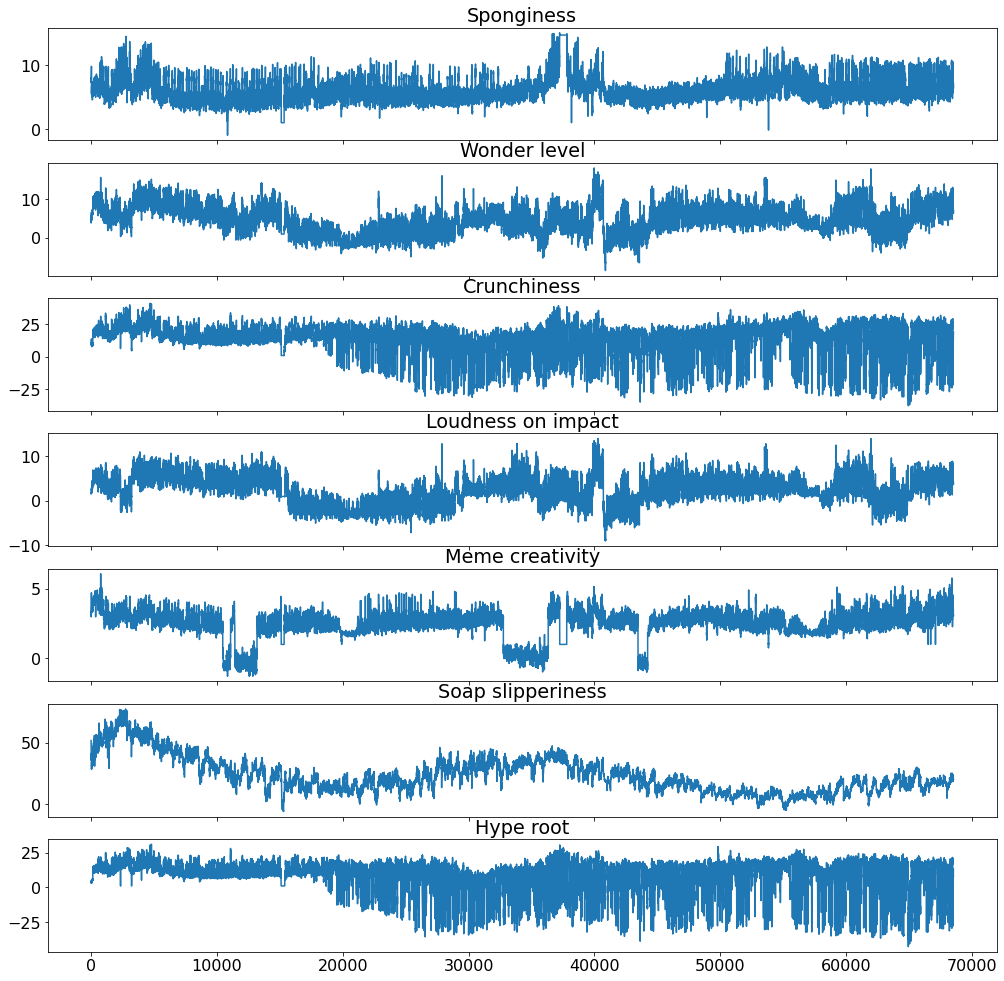

In [ ]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

Sequential Train-Test split and normalization

In [ ]:
print((dataset.shape))

(68528, 7)


(63528, 7) (5000, 7)


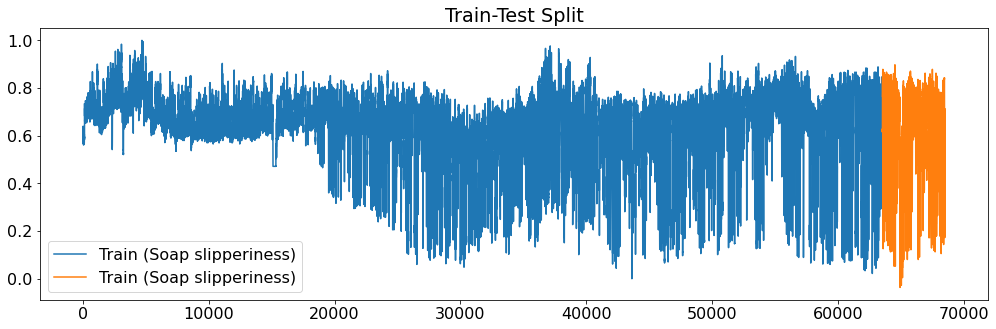

In [ ]:
test_size = 5000
X_train_raw = dataset.iloc[:-test_size]
# y_train_raw = y.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]

# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Crunchiness, label='Train ('+values+')')
plt.plot(X_test_raw.Crunchiness, label='Train ('+values+')')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [ ]:
print('X_min')
print(X_min)
print('X_max')
print(X_max)

X_min
Sponginess            -0.972080
Wonder level          -8.450380
Crunchiness          -34.802881
Loudness on impact    -9.028060
Meme creativity       -1.275860
Soap slipperiness     -6.006860
Hype root            -38.816760
dtype: float64
X_max
Sponginess            15.106680
Wonder level          18.122899
Crunchiness           41.138801
Loudness on impact    14.035980
Meme creativity        6.056360
Soap slipperiness     77.371620
Hype root             31.024420
dtype: float64


###Autocorrelation

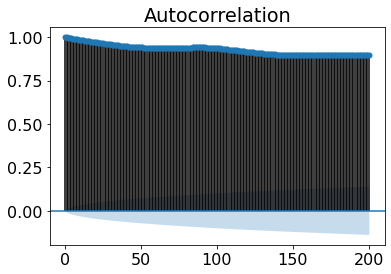

In [ ]:
plot_acf(dataset[values],lags=200)
plt.show()

##Implementing Moving Average

Moving average process is a family of stationary processes. It has a costant mean value, a costant variance, and the covariance function depends only on the difference $t_1-t_2$ (the two time instants).
A Moving Average process is defined like:


*   $MA(1)=C_0\eta(t)+C_1\eta(t-1)$
*   $MA(2)=C_0\eta(t)+C_1\eta(t-1)+C_2\eta(t-2)$

where $\eta(t)\sim wn$


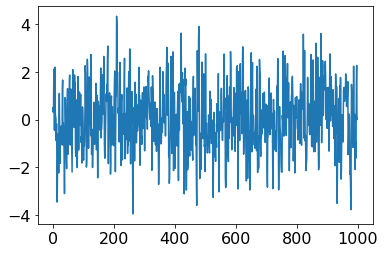

In [ ]:
# simulate an MA(1) with theta of 0.5
from statsmodels.tsa.arima_process import ArmaProcess

# no AR component
ar1 = np.array([1])

# MA of order 1 with theta of 0.5
ma1 = np.array([1, 0.9])

# Generate and plot the data
ma1 = ArmaProcess(ar1, ma1) #this function is inside the statistic toolbox.
simulated_ma1 = ma1.generate_sample(nsample=1000)
plt.plot(simulated_ma1);

In [ ]:
# Create a MA(1)
from statsmodels.tsa.arima_model import ARMA

ma1_model = ARMA(dataset[values], order=(0,1)) #the first argument is the order of the autoregressive part, and the second of the moving average part.

# fit the model
ma1_result = ma1_model.fit()

# print the parameters
print(ma1_result.summary())

print("μ=%.3f θ=%.3f"%(ma1_result.params[0],ma1_result.params[1]))

                              ARMA Model Results                              
Dep. Variable:      Soap slipperiness   No. Observations:                68528
Model:                     ARMA(0, 1)   Log Likelihood             -234288.791
Method:                       css-mle   S.D. of innovations              7.388
Date:                Tue, 04 Jan 2022   AIC                         468583.581
Time:                        13:46:26   BIC                         468610.986
Sample:                             0   HQIC                        468592.042
                                                                              
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      23.2382      0.056    418.483      0.000      23.129      23.347
ma.L1.Soap slipperiness     0.9675      0.001   1421.325      0.000       0.966       0.969


In [ ]:
temp = 'Models/' + title

# saving model
if not os.path.exists('Models/'+title):
  os.makedirs('Models/'+title)
  ma1_result.save(temp+'/'+title)
  print('Model correctly saved')
else:
  print('ERROR')

Model correctly saved


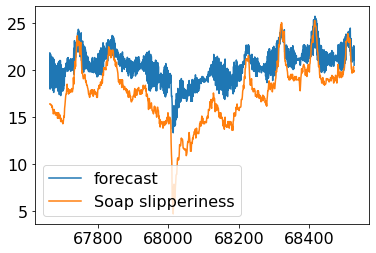

In [ ]:
g = ma1_result.plot_predict(start=-864)

In [ ]:
predict= ma1_result.predict(start = -864)